In [17]:
# ---------- IMPORTAÇÃO DAS BIBLIOTECAS ---------- #

import numpy as np
import pandas as pd
import psycopg2
import pandas.io.sql as sqlio
import matplotlib.pyplot as plt
import seaborn as sns
import time

# ---------- CONEXÃO COM O BANCO DE DADOS ---------- #
# Parâmetros da Conexão
host    = 'lincpo.com.br'
port    = '2035'
dbname  = 'censo'
dbtable = 'censo_2000'
user    = 'prevdb_user'
pwd     = 'pr3v'

# Conexão com o Banco de Dados
conn = psycopg2.connect("host='{}' port={} dbname='{}'user={} password={}"
         .format(host, port, dbname, user, pwd))

if conn == -1:
    print("Não foi possível conectar a Base de Dados")
else:
    print("Conectado com sucesso")

Conectado com sucesso


# **Censo Demográfico 2010 - Análise dos Benefícios e Indíce de Gini**

* Cálculo do indíce de Gini (renda percapita e percapita domiciliar) nas base de dados dos censos de: 
     * **1991** (?)
     * **2000**
     * **2010**
* Base de Dados disponível em: ftp://ftp.ibge.gov.br/Censos/
* Resultados divulgados pelo IBGE disponível em: http://www.atlasbrasil.org.br/2013/pt/consulta/
* Unidade de amostra: **Estados**
* Análise estátisca acerca da situação dos benefícios (aposentadorias e pensões)
* Anuário estatistico da previdência (ano 2000?): http://www.previdencia.gov.br/a-previdencia/politicas-de-previdencia-social/resultados-do-rgps/

## **1. Indíce de Gini**
* Indicador que mede a desigualdade de renda
* G = 1 corresponde a total desigualdade e G = 0 corresponde a total igualdade de renda
* Pode ser cálculado como:

$G = 1 - CurvaLorenz$

ou 

$G = 1 - \sum_{i=1}^{k=n-1} (p_{k+1} - p_{k})(r_{k+1} + r_{k})$
* Onde: 
    - G - Coeficiente de Gini
    - P - Proporção acumulada da "população"
    - R - Proporção acumulada de "renda"
    
* Obs: é necessário organizar **R** de forma crescente: 

$r_{1} ≤ r_{2} ≤ r_{3} ... ≤ r_{i} ≤ ... ≤ r_{n}$

In [2]:
# ---------- CALCULO DO ÍNDICE DE GINI ---------- #

def gini( sql ):
    df = pd.read_sql_query( sql, conn )
    
    # Separa valores em renda e população
    renda = df[ 'renda' ]
    pessoas = df[ 'peso' ]
    
    # Transforma as listas em arrays
    pessoas = np.array( pessoas )
    renda = np.array( renda )

    # Organiza os dados
    aux = np.argsort( [ renda/pessoas for renda, pessoas in zip( renda, pessoas ) ], kind = "stable")
    
    renda = [j for _, j in zip( aux, renda[ aux ] )]
    pessoas = [i for _, i in zip(aux, pessoas[ aux ] )]

    # Soma acumulada de renda e pessoas 
    renda = np.cumsum( renda / sum( renda ) )
    pessoas = np.cumsum( pessoas / sum( pessoas ) )
    
    # Fŕomula do indíce de gini [ Gini = 1 - CurvaLorenz]
    g = 2 * ( 0.5 - np.trapz( renda, pessoas ) )
    
    return g, pessoas, renda

In [3]:
# ---------- PLOT DA CURVA DE LORENZ---------- #

def plotagem( pessoas, renda ):
    plt.plot( pessoas, renda, 'k' )
    plt.plot( [ 0, 1 ], 'r' )
    plt.ylim( 0, 1 ), plt.xlim( 0, 1 )
    plt.fill_between( pessoas, renda, facecolor = 'y' )

    plt.xlabel( 'Proporção de população' )
    plt.ylabel( 'Proporção de renda' )
    plt.title( 'Curva de Lorenz' )
    plt.show()

### **Variáveis de Interesse da Base de Dados**

------------ 
* Variáveis de domicílios:
    - **v0001** - Código do estado
    - **v0002** - Código município 
    - **v6529** - Rendimento domiciliar
    - **v0401** - Número de moradores do domicílio
    - **v0001**  - Peso da amostra associado a quantas vezes o registro se repete

------------    
* Variáveis de pessoas:
    - **v0001** - Código do estado
    - **v0002** - Código município 
    - **v6527** - Rendimento total
    - **v0656** - Se tinha rendimento proveninete de benefício público
        - 1 - Sim
        - 0 - Não
        - 9 - Ignorado
    - **v0659** - Se tinha rendimento proveninete de benefício privado
        - 1 - Sim
        - 0 - Não
        - 9 - Ignorado
    - **v6591** - Valor total dos rendimentos nas categorias v0656 e v0659
    - **v0001** - Peso da amostra associado a quantas vezes o registro se repete
------------ 

### **Unidades Federativas e Indíce de Gini**

| UF                  | Código | Gini 1991 | Gini 1991* | Gini 2000 | Gini 2000* | Gini 2010 | Gini 2010* |
|---------------------|--------|-----------|------------|-----------|------------|-----------|------------|
| Acre                | 12     | 0,63      | 0          | 0,64      | 0,6233     | 0,63      | 0          |
| Alagoas             | 27     | 0,63      | 0          | 0,68      | 0,6615     | 0,63      | 0          |
| Amapá               | 16     | 0,58      | 0          | 0,62      | 0,6126     | 0,6       | 0          |
| Amazonas            | 13     | 0,62      | 0          | 0,67      | 0,6569     | 0,65      | 0          |
| Bahia               | 29     | 0,67      | 0          | 0,66      | 0,6467     | 0,62      | 0          |
| Ceará               | 23     | 0,66      | 0          | 0,67      | 0,6431     | 0,61      | 0          |
| Distrito Federal    | 53     | 0,62      | 0          | 0,63      | 0,6226     | 0,63      | 0          |
| Espírito Santo      | 32     | 0,6       | 0          | 0,6       | 0,5947     | 0,56      | 0          |
| Goiás               | 52     | 0,59      | 0          | 0,6       | 0,6163     | 0,55      | 0          |
| Maranhão            | 21     | 0,6       | 0          | 0,65      | 0,6489     | 0,62      | 0          |
| Mato Grosso do Sul  | 50     | 0,6       | 0          | 0,62      | 0,6221     | 0,56      | 0          |
| Mato Grosso         | 51     | 0,6       | 0          | 0,62      | 0,6221     | 0,55      | 0          |
| Minas Gerais        | 31     | 0,61      | 0          | 0,61      | 0,6035     | 0,56      | 0          |
| Paraíba             | 25     | 0,64      | 0          | 0,63      | 0,6258     | 0,61      | 0          |
| Paraná              | 41     | 0,6       | 0          | 0,6       | 0,5976     | 0,53      | 0          |
| Pará                | 15     | 0,62      | 0          | 0,65      | 0,6310     | 0,62      | 0          |
| Pernambuco          | 26     | 0,65      | 0          | 0,66      | 0,6526     | 0,62      | 0          |
| Piauí               | 22     | 0,64      | 0          | 0,65      | 0,6424     | 0,61      | 0          |
| Rio de Janeiro      | 33     | 0,61      | 0          | 0,6       | 0          | 0,59      | 0          |
| Rio Grande do Norte | 24     | 0,63      | 0          | 0,64      | 0,6348     | 0,6       | 0          |
| Rio Grande do Sul   | 43     | 0,59      | 0          | 0,58      | 0,5772     | 0,54      | 0          |
| Rondônia            | 11     | 0,62      | 0          | 0,6       | 0,6022     | 0,56      | 0          |
| Roraima             | 14     | 0,63      | 0          | 0,61      | 0,6036     | 0,63      | 0          |
| Santa Catarina      | 42     | 0,55      | 0          | 0,56      | 0,5538     | 0,49      | 0          |
| São Paulo           | 35     | 0,55      | 0          | 0,58      | 0          | 0,56      | 0          |
| Sergipe             | 28     | 0,63      | 0          | 0,65      | 0,6395     | 0,62      | 0          |
| Tocantins           | 17     | 0,63      | 0          | 0,65      | 0,6411     | 0,6       | 0          |

* Fonte: IBGE (2018)
* ($*$) Resultados do algoritmo

In [4]:
# ---------- CALCULO DO ÍNDICE DE GINI PARA RENDA DOMICILIAR ---------- #

estados = [ "ac", "al", "am", "ap", "ba", "ce", "df", "es", "go", "ma", "mg", "ms", "mt",
          "pa", "pb", "pe", "pi", "pr", "rj", "rn", "ro", "rr", "rs", "sc", "se", 
          "sp1", "sp2_rm", "to" ]

results = []

for k in estados:
    
    # Seleciona os estados e municpios
    sql = "SELECT DISTINCT( v0002 ) AS cidade FROM censo_2010.domicilios_%s" % k
    cidades = pd.read_sql_query( sql, conn )

    for i in cidades['cidade']:
        
        # Referenciando estado e cidade (k, i)
        
        # SQL - índice de gini renda domiciliar  
        sql_RD = "SELECT \
                COALESCE( ( v6529 * v0010 ), 0 ) AS renda, ( v0010 ) AS peso \
                FROM censo_2010.domicilios_%s \
                WHERE v0002 = '%s'" %( k, i )
        
        # SQL - índice de gini renda per capita
        sql_RP = "SELECT \
                COALESCE( ( v6529 * v0010 ), 0 ) AS renda, ( v0010 * v0401 ) AS peso \
                FROM censo_2010.domicilios_%s \
                WHERE v0002 = '%s'" %( k, i )

        # SQL - renda per capita
        sql_Renda = "SELECT \
                    ( SUM( v6529 * v0010 ) / SUM( v0401 * v0010 ) ) AS RP \
                    FROM censo_2010.domicilios_%s \
                    WHERE v0002 = '%s'" %( k, i )
        
        # SQL - Unidade Federativa
        sql_UF = "SELECT v0001 as UF FROM censo_2010.domicilios_%s limit 1 " %( k )
        
        df_Renda = pd.read_sql_query( sql_Renda, conn )
        df_UF = pd.read_sql_query( sql_UF, conn )
        
        # Ajuste da renda per capita de julho de 2000 para valores em agosto de 2010
        # 99,19% de inflação no INCP
        # renda2010 = df_Renda.loc[ 0, 'rp' ] + ( df_Renda.loc[ 0, 'rp' ] * 0.9919037 )
        
        # Obs: A função "gini()" retorna um array com [índice de gini], ...
        # proporção acumulado da população] e [proporção acumulada de renda]
        
        g_RD = gini( sql_RD )
        g_RP = gini( sql_RP )
        
        # Adiciona valores no array resultado
        # || ID do municipio || Gini RD || Gini RP || Renda2000 || Renda2010 ||
        results.append( [ df_UF.loc[ 0, 'uf' ] + i,
                         g_RD[ 0 ], 
                         g_RP[ 0 ], 
                         df_Renda.loc[ 0, 'rp' ], 
                         df_Renda.loc[ 0, 'rp' ] ] )

        
# Salva em um arquivo .csv
gini_domicilio = pd.DataFrame( results, columns = 'Cod Gini_RD Gini_RP RendaMedia RendaMedia2010'.split() )
gini_domicilio.to_csv( 'results/gini2010.csv', sep = '\t' )
        
print( "Processamento do cálculo do índice de Gini (ano 2010) realizado com sucesso" )

Processamento do cálculo do índice de Gini (ano 2010) realizado com sucesso


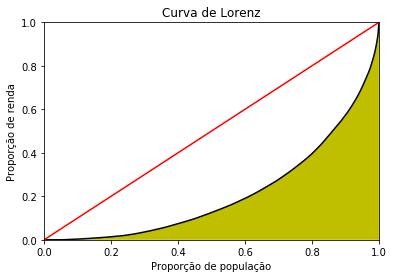

In [5]:
# Ilustração de curva de Lorenz

plotagem(g_RP[ 1 ], g_RP[ 2 ])

## **2. Participação dos benefícios de aposentadorias e pensões**

### **Rendimento de beneficios por estados**
* Renda e percentual para o total dos estados
* Renda e percentual para **aposentadorias** e **pensões** para cada estado
* Renda e percentual para **aposentadorias** e **pensões** até 1 salário mínimo
* Renda e percentual para **aposentadorias** e **pensões** acima de 1 salário mínimo
* Foi utilizado o software [Pentaho Data Integration](https://sourceforge.net/projects/pentaho/) para a realização das consultas na base de dados

In [11]:
# ---------- RESULTADOS DAS PARTICIPAÇÕES DE BENEFICIOS NO BRASIL - ESTADOS ---------- #

estados = [ "ac", "al", "am", "ap", "ba", "ce", "df", "es", "go", "ma", "mg", "ms", "mt",
          "pa", "pb", "pe", "pi", "pr", "rj", "rn", "ro", "rr", "rs", "sc", "se", 
          "sp1", "sp2_rm",  "to" ]

results = []

for k in estados: 
    # Rendimento total do estado
    sql_RT = "SELECT SUM( v6527 * v0010 ) AS RT \
            FROM censo_2010.pessoas_%s" %k

    # Rendimento total dos beneficios do estado
    sql_RB = "SELECT SUM( v6591 * v0010 ) AS RB \
            FROM censo_2010.pessoas_%s WHERE v0656 = 1" %k

    # Rendimento total dos beneficios acima de 1 salário minímo
    sql_RB_nSAL = "SELECT SUM( v6591 * v0010 ) AS RB_nSAL \
            FROM censo_2010.pessoas_%s WHERE v0656 = 1 AND v6591 > 510" %k

    # Rendimento total dos beneficios igual ou menor que 1 salário minímo
    sql_RB_1SAL = "SELECT SUM( v6591 * v0010 ) AS RB_1SAL \
            FROM censo_2010.pessoas_%s WHERE v0656 = 1 AND v6591 <= 510" %k

    df_RT = pd.read_sql_query( sql_RT, conn )
    df_RB = pd.read_sql_query( sql_RB, conn )
    df_RB_nSAL = pd.read_sql_query( sql_RB_nSAL, conn )
    df_RB_1SAL = pd.read_sql_query( sql_RB_1SAL, conn )

    RT = df_RT.loc[ 0, 'rt' ]
    RB = df_RB.loc[ 0, 'rb' ]
    RB_nSAL = df_RB_nSAL.loc[ 0, 'rb_nsal' ]
    RB_1SAL = df_RB_1SAL.loc[ 0, 'rb_1sal' ]

    results.append( [ k,
                      RT,
                      RB,
                      RB / RT,
                      RB_nSAL,
                      RB_nSAL / RT,
                      RB_1SAL,
                      RB_1SAL / RT] )

#results.append( [ "br", np.sum( results, axis=0 ) ] )

beneficios_2010_uf = pd.DataFrame( results, columns = "UF Renda(Total)\
                                                    Renda(Beneficios) Total(%)\
                                                    Beneficio(>Sal) Beneficio(>Sal)(%)\
                                                    Beneficio(<=Sal) Beneficio(<=Sal)(%)".split() )

beneficios_2010_uf.to_csv( 'results/beneficios2010_uf.csv', sep = '\t' )
        
print( "Processamento do cálculo dos benfícios (ano 2010) realizado com sucesso" )

Processamento do cálculo dos benfícios (ano 2010) realizado com sucesso


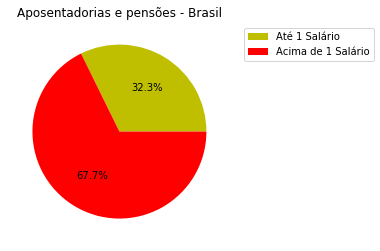

In [12]:
# Plotagem da participação de aposentadorias e pensões no total para o Brasil
import matplotlib.pyplot as plt

# Percentual de participação dos beneficios em todo o Brasil
p_total = beneficios_2010_uf['Total(%)'].sum() * 100 

# Percentual de participação dos beneficios <= 1 sal em todo o Brasil
p_um_sal = beneficios_2010_uf['Beneficio(<=Sal)(%)'].sum() * 100 

# Percentual de participação dos beneficios > 1 sal em todo o Brasil
p_mais_um_sal = beneficios_2010_uf['Beneficio(>Sal)(%)'].sum() * 100

p_total_sal = [ ( ( p_um_sal * 100 ) / p_total ), ( ( p_mais_um_sal * 100 ) / p_total ) ] 

labels = 'Até 1 Salário','Acima de 1 Salário'
plt.pie( p_total_sal, colors = [ 'y', 'r' ], autopct = '%1.1f%%' )
plt.title( 'Aposentadorias e pensões - Brasil' )
plt.legend( labels, bbox_to_anchor = ( 1.05, 1 ) )
plt.show()

In [18]:
# ---------- RESULTADOS DAS PARTICIPAÇÕES DE BENEFICIOS NO BRASIL - CIDADES ---------- #

estados = [ "ac", "al", "am", "ap", "ba", "ce", "df", "es", "go", "ma", "mg", "ms", "mt",
          "pa", "pb", "pe", "pi", "pr", "rj", "rn", "ro", "rr", "rs", "sc", "se", 
          "sp1", "sp2_rm",  "to" ]

results = []

for k in estados: 

    # Seleciona os estados e municpios
    sql = "SELECT DISTINCT( v0002 ) AS cidade FROM censo_2010.domicilios_%s" % k
    cidades = pd.read_sql_query( sql, conn )
    
    for i in cidades['cidade']:
        
        # Referenciando estado e cidade (k, i)
        
        # Rendimento total da cidade
        sql_RT = "SELECT COALESCE( SUM( v6591 * v0010 ), 0 ) AS RT \
                FROM censo_2010.pessoas_%s WHERE v0002 = '%s'" %( k, i )

        # Rendimento total dos beneficios da cidade
        sql_RB = "SELECT COALESCE( SUM( v6591 * v0010 ), 0 ) AS RB \
                FROM censo_2010.pessoas_%s WHERE v6591 <> 0 AND v0656 = 1 AND v0002 = '%s'" %( k, i )

        # Rendimento total dos beneficios acima de 1 salário minímo
        sql_RB_nSAL = "SELECT COALESCE( SUM( v6591 * v0010 ), 0 ) AS RB_NSAL \
                FROM censo_2010.pessoas_%s WHERE v6591 <> 0 AND v0656 = 1 AND v6591 > 510 AND v0002 = '%s'" %( k, i )

        # Rendimento total dos beneficios igual ou menor que 1 salário minímo
        sql_RB_1SAL = "SELECT COALESCE( SUM( v6591 * v0010 ), 0 ) AS RB_1SAL \
                FROM censo_2010.pessoas_%s WHERE v6591 <> 0 AND v0656 = 1 AND v6591 <= 510 AND v0002 = '%s'" %( k, i )

        # SQL - Unidade Federativa
        sql_UF = "SELECT v0001 as UF FROM censo_2010.domicilios_%s limit 1 " %( k )        
        
        df_UF = pd.read_sql_query( sql_UF, conn )
        df_RT = pd.read_sql_query( sql_RT, conn )
        df_RB = pd.read_sql_query( sql_RB, conn )
        df_RB_nSAL = pd.read_sql_query( sql_RB_nSAL, conn )
        df_RB_1SAL = pd.read_sql_query( sql_RB_1SAL, conn )

        RT = df_RT.loc[ 0, 'rt' ]
        RB = df_RB.loc[ 0, 'rb' ]
        RB_nSAL = df_RB_nSAL.loc[ 0, 'rb_nsal' ]
        RB_1SAL = df_RB_1SAL.loc[ 0, 'rb_1sal' ]
        
        results.append( [ k,
                          df_UF.loc[ 0, 'uf' ] + i,
                          RT,
                          RB,
                          RB / RT,
                          RB_nSAL,
                          RB_nSAL / RT,
                          RB_1SAL,
                          RB_1SAL / RT] )



beneficios_2010_cid = pd.DataFrame( results, columns = "COD UF Renda(Total)\
                                                    Renda(Beneficios) Total(%)\
                                                    Beneficio(>Sal) Beneficio(>Sal)(%)\
                                                    Beneficio(<=Sal) Beneficio(<=Sal)(%)".split() )

beneficios_2010_cid.to_csv( 'results/beneficios2010_cidades.csv', sep = '\t' )

print( "Processamento do cálculo dos benfícios para cidades (ano 2010) realizado com sucesso" )

Processamento do cálculo dos benfícios para cidades (ano 2010) realizado com sucesso


### **Medida de progressividade dos benefícios**